In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() \
                      else "cpu")
print("working on: " + str(DEVICE))

working on: cuda


In [4]:
RANDOM_SEED = 20200101
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# reproducibility with convolutions (btw, we do not use them)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
DB = pd.read_csv("./pmsm_temperature_data.csv")
DBs = [db[1] for db in DB.groupby("profile_id")]
np.random.shuffle(DBs)
print(DB.shape)
print(len(DBs))

(998070, 13)
52


In [6]:
DB.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [7]:
TARGET = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]
FEATURES = ["ambient", "coolant", "u_d", "u_q", "motor_speed", "i_d", "i_q"]

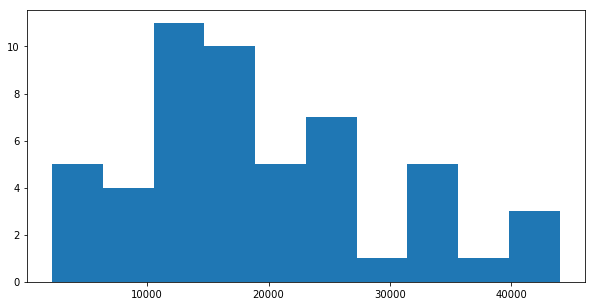

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(list(map(len, DBs)))
plt.show()

In [9]:
train_ratio = int(len(DBs) * 0.8)
TRAIN_SET = [df[FEATURES + TARGET] for df in DBs[:train_ratio]]
TEST_SET  = [df[FEATURES + TARGET] for df in DBs[train_ratio:]]
print(len(TRAIN_SET), len(TEST_SET))

41 11


In [10]:
TRAIN_SET[0].describe()

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
count,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000
mean,-0.254768,0.308065,0.311843,-0.371160,-0.413286,0.394203,-0.208356,-0.286752,0.039736,-0.144018,-0.256677
std,0.205871,1.105947,0.792268,1.081078,0.996139,0.846065,0.827721,0.597834,1.065554,0.962844,0.847979
min,-5.239872,-1.078828,-1.614588,-1.388082,-1.222439,-2.288602,-3.287054,-1.649365,-1.354718,-1.560621,-1.567307
25%,-0.395809,-0.684271,0.293656,-1.275595,-1.222430,-0.329227,-0.248303,-0.840581,-0.984368,-1.068181,-1.072331
50%,-0.152411,-0.195273,0.336386,-1.158519,-1.136797,1.020404,-0.245716,-0.393474,-0.160798,-0.271204,-0.381549
75%,-0.128646,1.497615,0.359315,0.658458,0.425678,1.029143,-0.238446,0.239883,1.297375,0.977605,0.578718
max,0.078443,2.294652,2.229603,1.763444,1.997176,1.029227,2.889711,0.936801,1.770560,1.538679,1.261606


In [11]:
def normalize(data):
    X = pd.concat(data)
    mu = X.mean()
    sigma = np.sqrt(X.var())
    return lambda df: (df - mu) / sigma

In [12]:
train_normalizer = normalize(TRAIN_SET)
N_TRAIN_SET = [train_normalizer(df) for df in TRAIN_SET]
N_TEST_SET =  [train_normalizer(df) for df in TEST_SET]

In [13]:
N_TRAIN_SET[0].describe()

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
count,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000,15300.000000
mean,-0.269204,0.277902,0.358784,-0.377951,-0.439544,0.409669,-0.235742,-0.361731,0.000581,-0.187840,-0.294977
std,0.212864,1.084690,0.791514,1.072156,0.984533,0.830689,0.845885,0.604627,1.063754,0.963059,0.841830
min,-5.423643,-1.082334,-1.565814,-1.386481,-1.239269,-2.224380,-3.382001,-1.739827,-1.391517,-1.604759,-1.596102
25%,-0.415036,-0.695360,0.340615,-1.274922,-1.239260,-0.300614,-0.276565,-0.921853,-1.021793,-1.112209,-1.104716
50%,-0.163370,-0.215761,0.383304,-1.158812,-1.154625,1.024489,-0.273921,-0.469666,-0.199615,-0.315054,-0.418944
75%,-0.138797,1.444589,0.406212,0.643169,0.389645,1.033070,-0.266492,0.170888,1.256095,0.934033,0.534360
max,0.075325,2.226306,2.274720,1.739036,1.942833,1.033153,2.930312,0.875724,1.728481,1.495232,1.212296


# Neural Networks

In [14]:
BATCH_SIZE = 512
LEN = 10
EPOCHS = 50

In [15]:
def plot_history(history):
    train_col = "red"
    test_col = "orange"
    for feature in ["loss"] + ["R2_" + t for t in TARGET]:
        plt.plot(history["_".join([feature, "train"])],
                 label="Train",
                 color=train_col)
        plt.plot(history["_".join([feature, "test"])],
                 label="Test",
                 color=test_col)
        plt.xlabel("Epoch")
        plt.ylabel("Value")
        plt.title(feature)
        plt.legend()
        plt.show()

In [16]:
def predict(mod, serie, t0=LEN):
    Y_total = []
    Yhat_total = []
    mod.eval()
    for i in range(t0, len(serie)):
        X = serie[(i - t0):i, :]
        y = serie[i, len(FEATURES):]
        y_hat = mod(X.reshape((1,) + X.shape))
        Y_total.append(y)
        Yhat_total.append(y_hat)
    return torch.stack(Yhat_total).cpu().detach().numpy(), \
        torch.stack(Y_total).cpu().detach().numpy()


def print_predictions(mod, serie, t0=LEN):
    y, y_hat = predict(mod, serie, t0)
    print(y.shape, y_hat.shape)
    for i, t in enumerate(TARGET):
        plt.plot(y[:, 0, i], color="black",
                 label="Real")
        plt.plot(y_hat[:, i], color="red",
                 label="Prevision")
        plt.xlabel("time")
        plt.ylabel(t)
        plt.legend()
        plt.show()

In [17]:
def dataloader(data, length=LEN, batch_size=BATCH_SIZE, shuffle=True):
    tuples = [[(df_i, i) for i in range(len(df)) if i > length]
              for df_i, df in enumerate(data)]
    tuples = sum(tuples, [])  # flattenize

    # shuffle
    if shuffle:
        np.random.shuffle(tuples)

    lim, Lim = 0, batch_size
    while lim < len(tuples):
        sample = tuples[lim:min(Lim, len(tuples))]
        X = torch.stack([data[df_i][(i-length):i, :]
                         for df_i, i in sample])
        Y = torch.stack([data[df_i][i, len(FEATURES):] \
                         for df_i, i in sample])
        yield X, Y
        lim, Lim = Lim, Lim + batch_size

In [18]:
TRAIN_SET_TENSOR = [torch.from_numpy(df.values).float().to(DEVICE) for df in N_TRAIN_SET]
TEST_SET_TENSOR =  [torch.from_numpy(df.values).float().to(DEVICE) for df in N_TEST_SET]

In [19]:
def R2(x, y):
    return np.corrcoef(x, y)[0, 1]**2


def evaluate(mod, loss_fn, data, length, batch_size):
    "Return loss and R² of the model given some data"

    # it set the model to evaluation mode (stop dropout and so on)
    mod.eval()

    # resutls for the whole evaluation procedure (return values)
    loss_total = []
    Y_total = []
    Yhat_total = []
    batch_size_total = []

    for X, Y in dataloader(data,
                           length=length,
                           batch_size=batch_size,
                           shuffle=False):
        Y_hat = mod(X)
        loss = loss_fn(Y_hat, Y)
        loss_total.append(loss.cpu().item())
        Y_total.append(Y.cpu().detach().numpy())
        Yhat_total.append(Y_hat.cpu().detach().numpy())
        batch_size_total.append(len(Y))

    Y_total = np.vstack(Y_total)
    Yhat_total = np.vstack(Yhat_total)
    _, p = Y_total.shape

    R2_total = [R2(Y_total[:, i], Yhat_total[:, i]) for i in range(p)]
    return np.average(loss_total, weights=batch_size_total), R2_total


def stop_early(patience_max, times_max=1):
    "Return a earl stopping checker"
    # (from: Goodfellow & Bengio)
    patience = 0
    times = 0
    min_loss = np.Inf

    def check(loss):
        "Return if the train process must stop early"
        nonlocal patience, times, min_loss
        if loss > min_loss:
            patience += 1
            if patience >= patience_max:
                patience = 0
                times += 1
                if times >= times_max:
                    return True
        else:
            min_loss = loss
            patience = 0
        return False
    return check

In [20]:
def train(mod, loss_fn, optimizer,
          train_set, test_set,
          epochs=EPOCHS, batch_size=BATCH_SIZE, previous_size=LEN,
          early_stopping=None,
          verbose=True):
    "Train the model"

    R2_strings = ["_".join(["R2", t, s])
                  for t in TARGET
                  for s in ["train", "test"]]
    # history of the train process
    history = {label: [] for label in R2_strings}
    history["time"] = []
    history["loss_train"] = []
    history["loss_test"] = []

    # repeat for tot epochs
    for epoch in range(epochs):

        # it set the model in train mode (start dropout)
        mod.train()

        # just to know how much does it take
        start = datetime.now()

        for X, Y in dataloader(train_set,
                               length=previous_size,
                               batch_size=batch_size):
            optimizer.zero_grad()             # reset gradient
            Y_hat = mod(X)                    # make predictions!
            loss = loss_fn(Y_hat, Y)          # compute loss
            loss.backward(retain_graph=True)  # calc direction of GD
            optimizer.step()                  # do a little step to the optimum

        time = datetime.now() - start  # ok, it lasts tot (always too much) seconds

        # just compute and store results
        history["time"].append(time)

    
        loss, r2 = evaluate(mod, loss_fn, train_set, previous_size, batch_size)
        history["loss_train"].append(loss)
        for c, rho in zip(TARGET, r2):
            history["R2_" + c + "_train"].append(rho)

        loss, r2 = evaluate(mod, loss_fn, test_set, previous_size, batch_size)
        history["loss_test"].append(loss)
        for c, rho in zip(TARGET, r2):
            history["R2_" + c + "_test"].append(rho)
        
        # print how good is our model
        if verbose:
            print(epoch + 1, end="\t")
            print(str(time), end="\t")
            for val in ["loss"] + ["R2_" + t for t in TARGET]:
                print(val, end=": ")
                print("(%.3f, %.3f)" % (history[val + "_train"][-1],
                                        history[val + "_test"][-1]),
                      end="\t")
            # for val in ["loss_train", "loss_test"] + R2_strings:
            #     print(val, end=": ")
            #     print("%.3f" % history[val][-1], end="\t")
            print("", end="\r")
        
        # stop the process if it start to degenerate
        if early_stopping is not None and early_stopping(history["loss_test"][-1]):
            break

    return history

In [21]:
def fast_train(mod, loss_fn, optimizer,
               train_set, test_set,
               epochs=1,
               previous_size=LEN, batch_size=BATCH_SIZE,
               verbose=False):
    start = datetime.now()
    
    for epoch in range(epochs):
        mod.train()
        for X, y in dataloader(train_set,
                               previous_size,
                               batch_size):
            loss_fn(mod(X), y).backward()
            optimizer.step()

    mod.eval()
    loss = np.sum([loss_fn(mod(X), y).cpu().item()
                   for X, y in dataloader(test_set,
                                          previous_size,
                                          batch_size,
                                          shuffle=False)])

    if verbose:
        print(str(datetime.now() - start), "%.3f" % loss, end="\r")

    return loss

## Recurrent NN

In [22]:
class Custom_RNN(torch.nn.Module):

    def __init__(self, hiddens, recur,
                 regressors=[],
                 p_dropout=0.3):
        self.recur_input, self.recur_output = recur
        # recur_input in [0, len(hiddens)]
        # recur_output in [-1, len(hiddens)]
        assert 0 <= self.recur_input <= len(hiddens)
        assert -1 <= self.recur_output <= len(hiddens)
        assert len(regressors) in [0, len(TARGET)]

        super(Custom_RNN, self).__init__()
        input_shape = len(FEATURES) + len(TARGET)
        self.previous_size = hiddens[self.recur_output]
        
        hiddens_in = [input_shape] + hiddens

        hiddens[self.recur_output] if self.recur_output > 0 \
            else input_shape
        hiddens_in[self.recur_input] += self.previous_size

        self.dropout = torch.nn.Dropout(p=p_dropout)
        self.layers = torch.nn.ModuleList(
            [torch.nn.Linear(in_shape, out_shape) \
             for in_shape, out_shape in zip(hiddens_in, hiddens)])
        self.layers_fn = [torch.nn.functional.relu \
                          for _ in self.layers]

        regressor_list = []
        for regressor in regressors:
            input_shape = [hiddens[-1]] + regressor
            y_net = [torch.nn.ReLU() for _ in input_shape + regressor]
            y_net[::2] = [torch.nn.Linear(in_shape, out_shape)
                          for in_shape, out_shape in zip(input_shape, regressor + [1])]
            regressor_list.append(torch.nn.Sequential(*y_net))
        self.regressors = torch.nn.ModuleList(regressor_list)

    def initialize_prev(self, x):
        return torch.zeros(len(x), self.previous_size).to(DEVICE)

    def forward(self, data, lag=None):
        _, l, _ = data.shape
        x = data[:, 0, :]
        if lag is None:  # first recursion
            lag = self.initialize_prev(x)
        for i, (layer, fn) in enumerate(zip(self.layers, self.layers_fn)):
            if i == self.recur_input:
                x = torch.cat([x, lag], axis=1)
            x = fn(layer(x))
            x = self.dropout(x)
            if i == self.recur_output and l > 1:
                return self.forward(data[:, 1:, :], x)
        x = torch.cat([regressor(x) for regressor in self.regressors ],
                      axis=1)
        if self.recur_output == -1 and l > 1:
            return self.forward(data[:, 1:, :], x)
        return x

# Ottimizzazione

In [23]:
import sherpa

In [24]:
def optimize(train_set, test_set, epochs=100):
    parameters = [
        sherpa.Discrete("hidden1", [10, 50]),
        sherpa.Discrete("hidden2", [10, 50]),
        sherpa.Discrete("hidden_pm", [3, 20]),
        sherpa.Discrete("hidden_yoke", [3, 20]),
        sherpa.Discrete("hidden_tooth", [3, 20]),
        sherpa.Discrete("hidden_winding", [3, 20]),
        sherpa.Discrete("input_rec", [0, 1]),
        sherpa.Discrete("output_rec", [0, 1]),
        sherpa.Discrete("window", [1, 10]),
        sherpa.Continuous("lr", [1e-3, 1e-5])]
    
    best_score = np.Inf

    alg = sherpa.algorithms.bayesian_optimization.GPyOpt(
        max_concurrent=1,
        model_type="GP",
        acquisition_type="EI",
        max_num_trials=epochs)

    study = sherpa.Study(parameters=parameters,
                         algorithm=alg,
                         lower_is_better=True,
                         disable_dashboard=True)

    for i, trial in enumerate(study):
        print(i + 1, end="\t")
        mod = Custom_RNN([int(trial.parameters["hidden1"]),
                          int(trial.parameters["hidden2"])],
                         (int(trial.parameters["input_rec"]),
                          int(trial.parameters["output_rec"])),
                         [[int(trial.parameters["hidden_pm"])],
                          [int(trial.parameters["hidden_yoke"])],
                          [int(trial.parameters["hidden_tooth"])],
                          [int(trial.parameters["hidden_winding"])]]).to(DEVICE)
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(params=mod.parameters(),
                                     lr=trial.parameters["lr"])

        loss = fast_train(mod, loss_fn, optimizer,
                          train_set, test_set,
                          epochs=2,
                          previous_size=int(trial.parameters["window"]),
                          verbose=True)

        if loss < best_score:
            best_score = loss
            torch.save(mod, "./models/best_model_rnn")
            print("")
    
        study.add_observation(trial, iteration=1, objective=loss)
        study.finalize(trial)
        study.results.to_csv("./results/AutoML_RNN.csv")

In [25]:
optimize(TRAIN_SET_TENSOR, TEST_SET_TENSOR, 250)

1	

0:00:20.314698 118.779
2	

3	

4	

5	

6	

0:00:22.106337 52.889
7	

8	

9	

10	

11	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


12	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


13	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


14	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


15	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


16	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


17	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


18	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


19	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


20	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


21	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


22	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


23	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


24	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


25	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


26	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


27	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


28	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


29	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


30	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


31	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


32	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


33	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


34	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


35	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


36	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


37	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


38	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


39	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


40	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


41	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


42	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


43	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


44	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


45	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


46	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


47	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


48	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


49	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


50	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


51	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


52	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


53	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


54	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


55	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


56	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


57	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


58	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


59	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


60	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


61	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


62	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


63	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


64	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


65	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


66	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


67	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


68	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


69	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


70	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


71	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


72	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


73	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


74	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


75	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


76	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


77	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


78	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


79	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


80	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


81	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


82	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


83	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


84	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


85	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


86	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


87	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


88	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


89	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


90	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


91	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


92	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


93	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


94	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


95	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


96	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


97	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


98	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


99	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


100	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


101	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


102	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


103	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


104	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


105	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


106	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


107	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


108	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


109	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


110	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


111	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


112	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


113	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


114	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


115	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


116	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


117	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


118	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


119	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


120	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


121	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


122	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


123	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


124	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


125	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


126	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


127	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


128	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


129	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


130	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


131	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


132	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


133	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


134	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


135	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


136	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


137	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


138	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


139	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


140	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


141	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


142	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


143	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


144	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


145	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


146	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


147	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


148	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


149	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


150	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


151	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


152	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


153	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


154	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


155	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


156	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


157	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


158	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


159	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


160	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


161	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


162	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


163	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


164	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


165	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


166	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


167	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


168	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


169	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


170	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


171	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


172	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


173	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


174	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


175	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


176	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


177	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


178	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


179	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


180	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


181	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


182	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


183	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


184	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


185	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


186	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


187	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


188	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


189	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


190	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


191	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


192	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


193	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


194	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


195	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


196	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


197	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


198	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


199	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


200	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


201	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


202	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


203	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


204	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


205	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


206	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


207	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


208	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


209	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


210	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


211	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


212	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


213	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


214	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


215	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


216	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


217	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


218	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


219	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


220	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


221	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


222	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


223	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


224	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


225	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


226	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


227	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


228	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


229	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


230	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


231	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


232	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


233	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


234	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


235	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


236	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


237	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


238	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


239	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


240	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


241	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


242	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


243	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


244	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


245	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


246	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


247	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


248	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


249	

INFO:GP:initializing Y


INFO:GP:initializing inference method


INFO:GP:adding kernel and likelihood as parameters


250	

In [26]:
results = pd.read_csv("./results/AutoML_RNN.csv")
results = results[results["Status"] == "COMPLETED"]
results.head()

,Unnamed: 0,Trial-ID,Status,Iteration,hidden1,hidden2,hidden_pm,hidden_tooth,hidden_winding,hidden_yoke,input_rec,lr,output_rec,window,Objective
1,1,1,COMPLETED,1,35.0,10.0,10.0,16.0,6.0,7.0,0.0,0.000642,0.0,1.0,118.779309
3,3,2,COMPLETED,1,26.0,36.0,4.0,18.0,17.0,7.0,0.0,0.000741,0.0,6.0,233.354502
5,5,3,COMPLETED,1,37.0,17.0,7.0,4.0,7.0,10.0,0.0,0.000884,0.0,7.0,206.735107
7,7,4,COMPLETED,1,17.0,45.0,14.0,17.0,18.0,6.0,0.0,0.000907,0.0,9.0,193.599461
9,9,5,COMPLETED,1,41.0,22.0,10.0,19.0,11.0,9.0,0.0,0.000773,0.0,3.0,226.962413


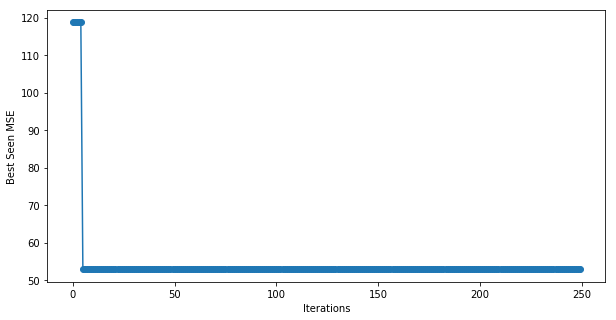

In [27]:
plt.figure(figsize=(10, 5))

plt.plot(np.minimum.accumulate(np.array(results["Objective"])),
         "o-")
plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [35]:
best_params = results.iloc[results["Objective"].idxmin()]

best_model = torch.load("./models/best_model_rnn")
best_optimizer = torch.optim.Adam(params=best_model.parameters(),
                                  lr=best_params["lr"])
loss_fn = torch.nn.MSELoss()

print(best_model)

Custom_RNN(
  (dropout): Dropout(p=0.3, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=26, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=29, bias=True)
  )
  (regressors): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=29, out_features=18, bias=True)
      (1): ReLU()
      (2): Linear(in_features=18, out_features=1, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=29, out_features=13, bias=True)
      (1): ReLU()
      (2): Linear(in_features=13, out_features=1, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=29, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=1, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=29, out_features=7, bias=True)
      (1): ReLU()
      (2): Linear(in_features=7, out_features=1, bias=True)
    )
  )
)


In [32]:
history = train(best_model, loss_fn, best_optimizer,
                TRAIN_SET_TENSOR, TEST_SET_TENSOR,
                previous_size=int(best_params["window"]),
                early_stopping=stop_early(5, 2))

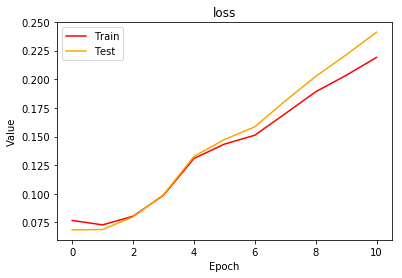

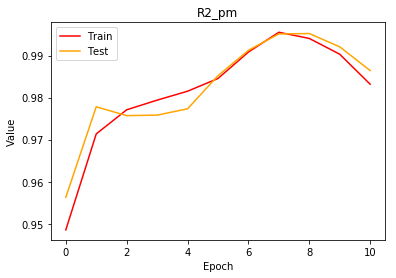

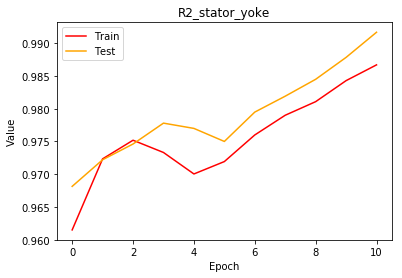

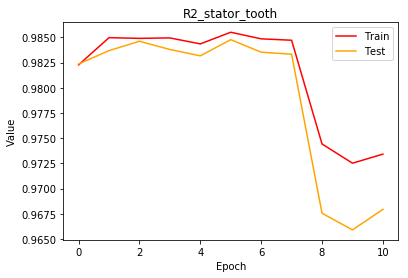

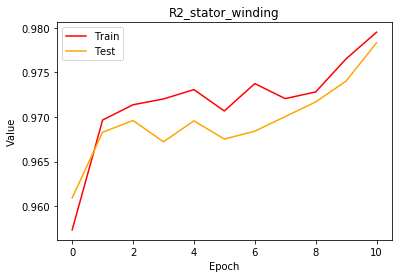

In [33]:
plot_history(history)

(14394, 1, 4) (14394, 4)


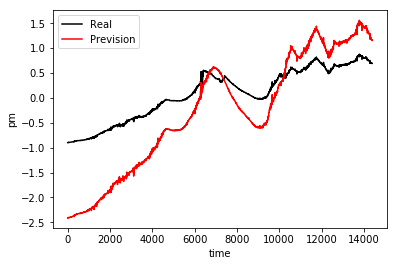

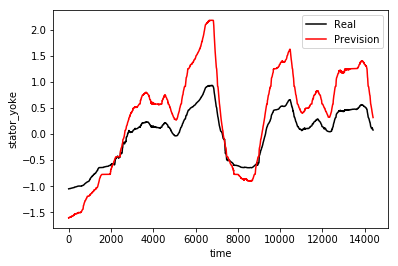

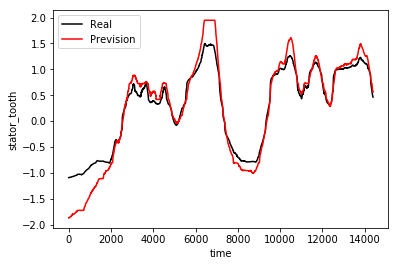

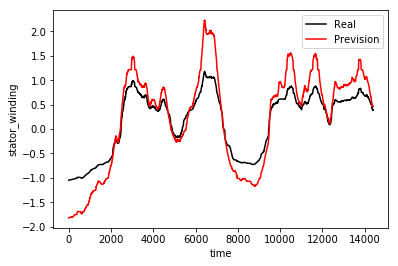

In [34]:
print_predictions(best_model, TEST_SET_TENSOR[0], int(best_params["window"]))